# Cellrank

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
%run ../scripts/helpers.py

In [3]:
adata_velocity = sc.read("../data/processed/04_scvelo.h5ad")

selected_cells = pd.read_csv("../results/03_subset_cells.csv", index_col=1)
adata = adata_velocity[selected_cells.index, ]

In [4]:
adata = run_scvelo(adata)

Trying to set attribute `.obs` of view, copying.


Filtered out 13986 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/224 cores)


  0%|          | 0/1198 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/1805 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
hto = sc.read("../data/processed/02_rna_hto.h5ad")
hto = hto[selected_cells.index, ]
adata.obs['HTO'] = hto.obs['HTO_classification']

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


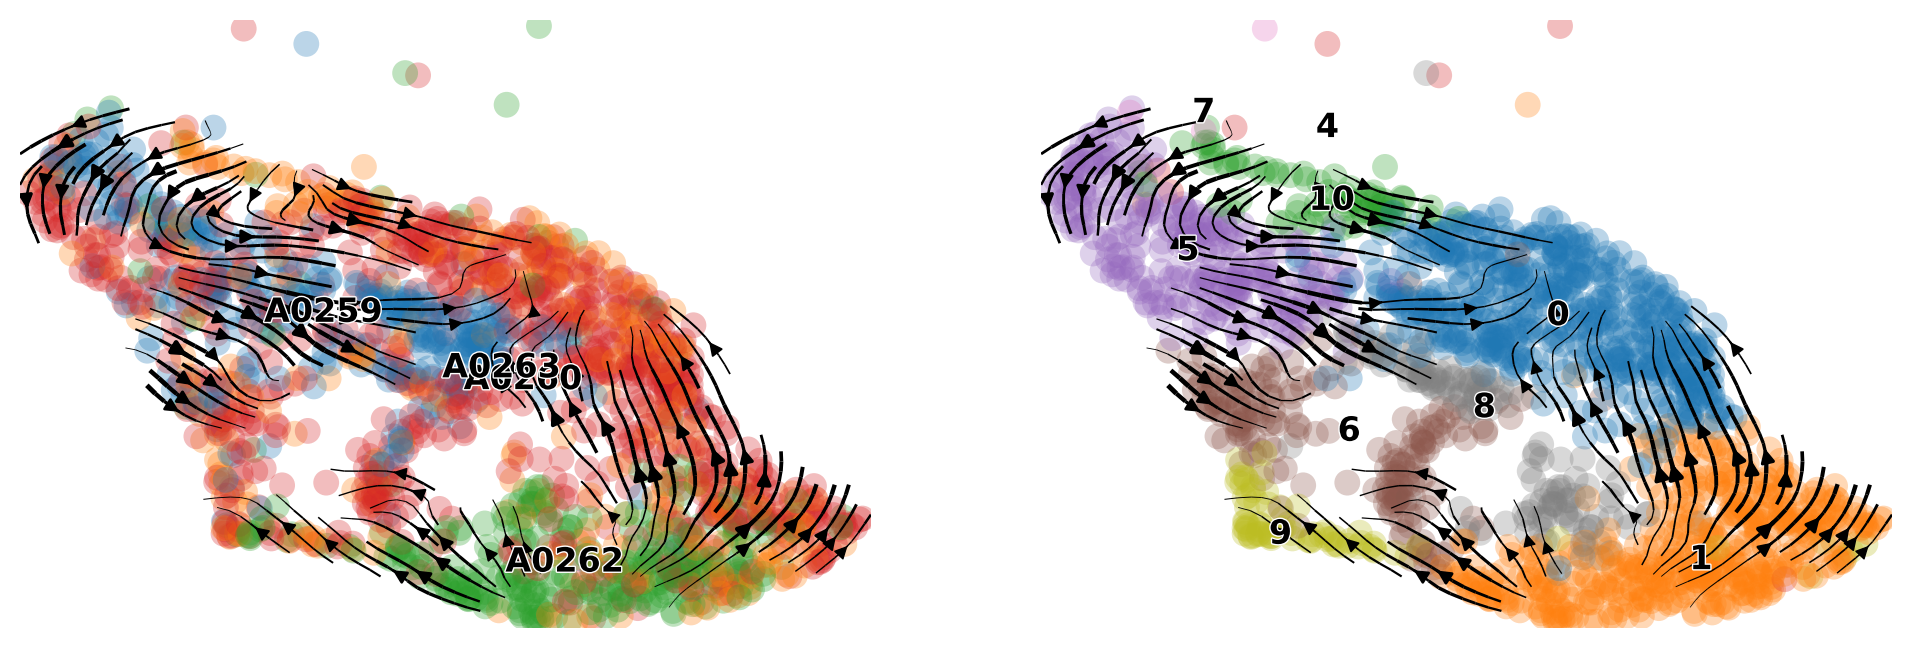

In [6]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", color=['HTO', 'seurat_clusters'], legend_fontsize=12, title="", smooth=0.8, min_mass=4
)

## Option #1: CellRank transition

**Note**: Sooo this method calculates VelocityKernel. Maybe other kernel should be included? What's up with the Schuch kernel here?

Tutorial: https://cellrank.readthedocs.io/en/stable/auto_examples/kernels/plot_random_walks.html#sphx-glr-auto-examples-kernels-plot-random-walks-py

In [7]:
k = cr.tl.transition_matrix(
    adata, weight_connectivities=0.2, softmax_scale=4, show_progress_bar=False
)
k

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  
Computing transition matrix based on logits using `'deterministic'` mode
    Finish (0:00:01)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


((0.8 * <VelocityKernel>) + (0.2 * <ConnectivityKernel>))

Simulating `100` random walks of maximum length `100`
    Finish (0:00:00)
Plotting random walks


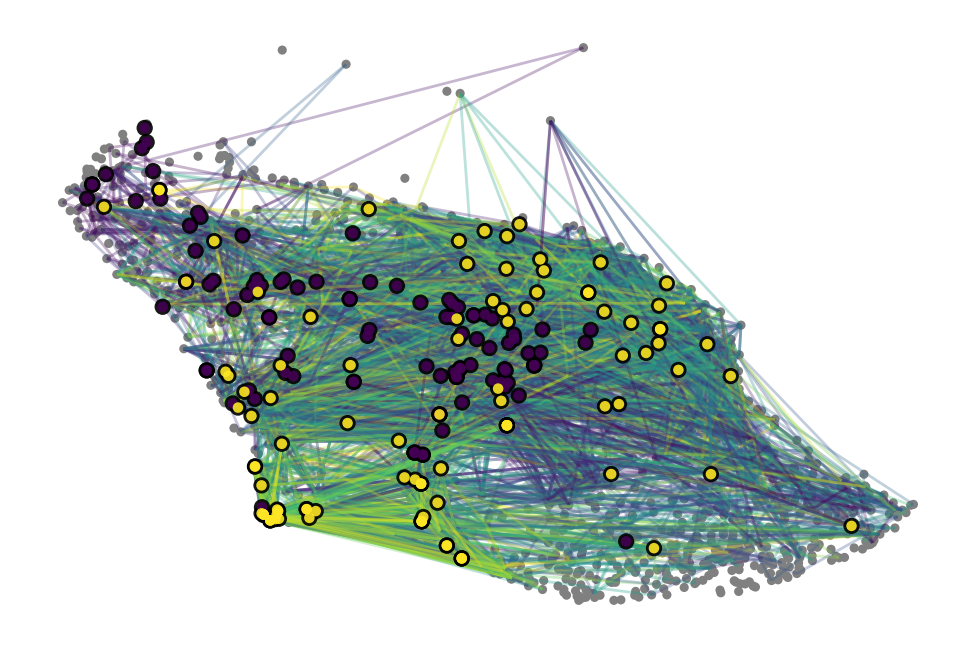

In [8]:
k.plot_random_walks(
    100, 
    start_ixs={"HTO": "A0259"},
    max_iter=100,
    successive_hits=5,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

Simulating `100` random walks of maximum length `100`
    Finish (0:00:01)
Plotting random walks


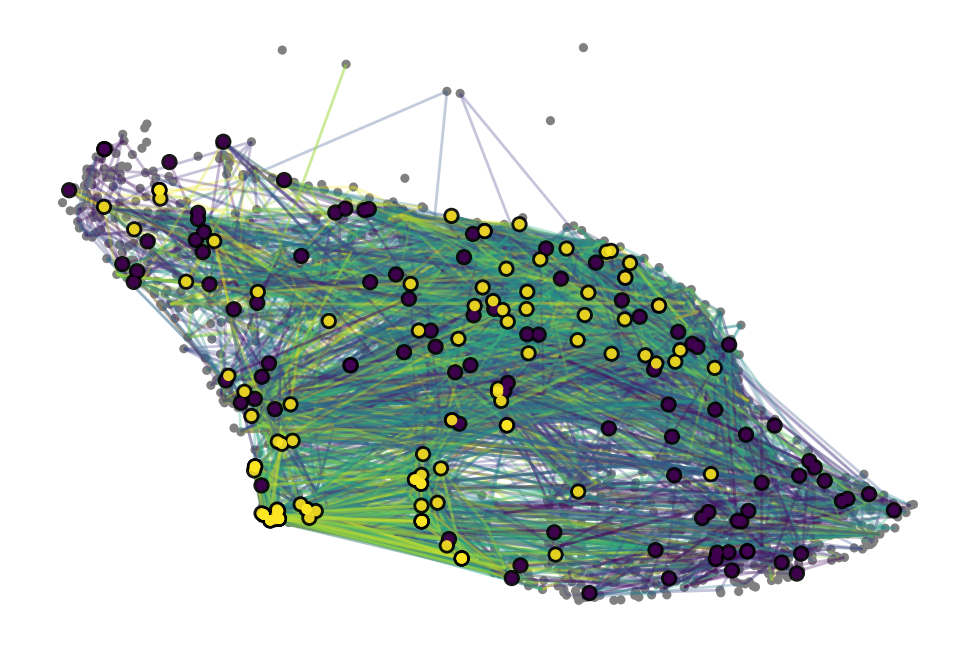

In [9]:
k.plot_random_walks(
    100,
    start_ixs={"HTO": "A0250"},
#     stop_ixs={"seurat_clusters": ["9"]},
    max_iter=100,
    successive_hits=5,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

Simulating `100` random walks of maximum length `100`
    Finish (0:00:00)
Plotting random walks


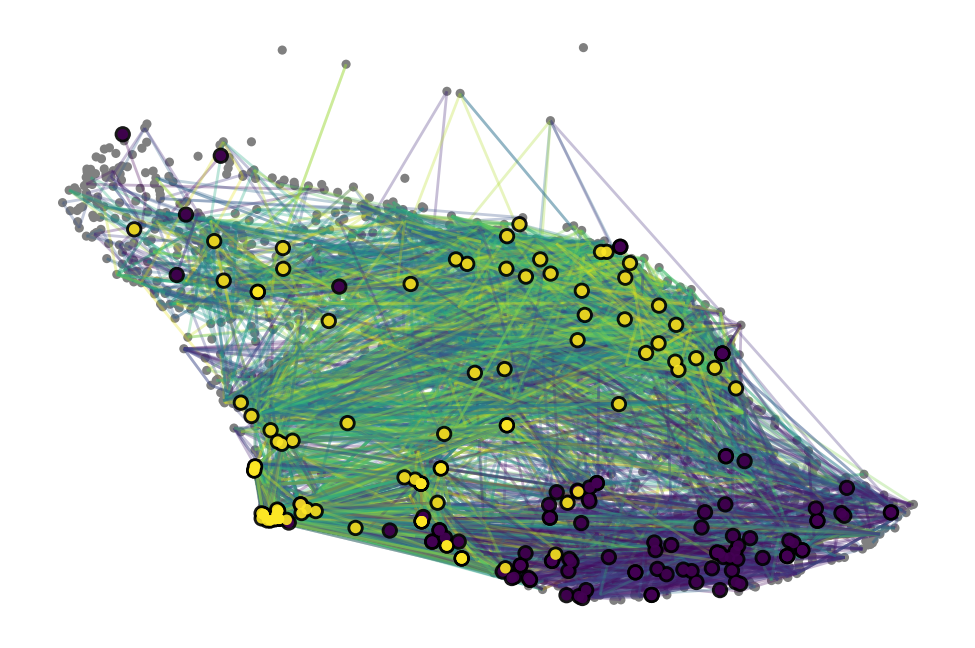

In [10]:
k.plot_random_walks(
    100,
    start_ixs={"HTO": "A0262"},
#     stop_ixs={"seurat_clusters": ["9"]},
    max_iter=100,
    successive_hits=5,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

Simulating `100` random walks of maximum length `100`
    Finish (0:00:00)
Plotting random walks


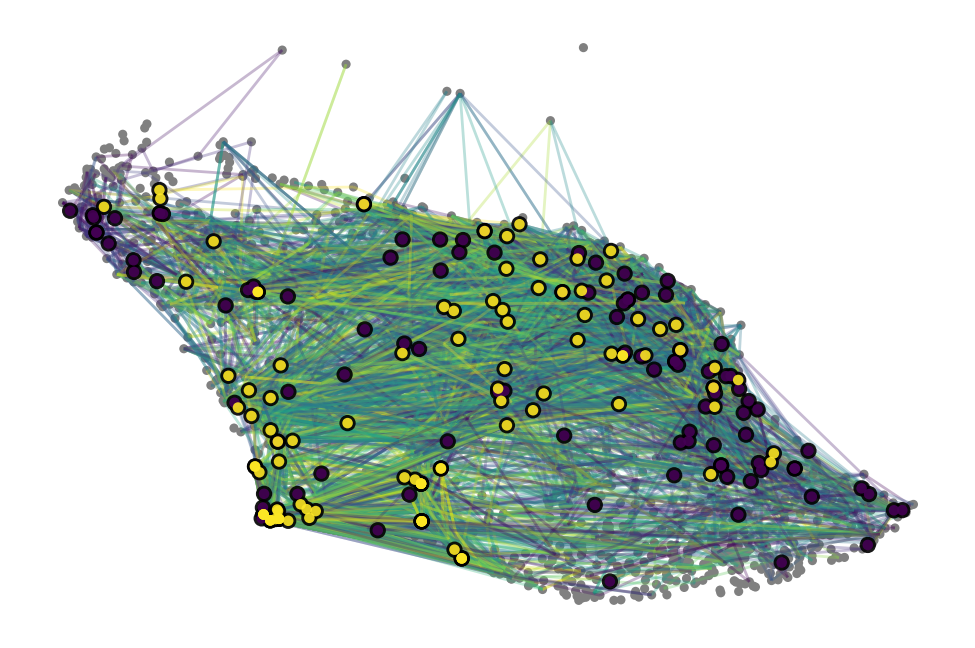

In [11]:
k.plot_random_walks(
    100,
    start_ixs={"HTO": "A0263"},
#     stop_ixs={"seurat_clusters": ["9"]},
    max_iter=100,
    successive_hits=5,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

## Option #2: Standard velocity

This is method where we use just velocity to estimate the transition. We can compute fate per cell. This might not be the best alternative as the velocities are noisy and this method doesn't account for that at all. The transition matrix is quite different when using `cellrank.tl.transition_matrix()`

In [12]:
trans_df = pd.DataFrame(scv.utils.get_transition_matrix(adata).todense(), 
                        index=adata.obs_names, 
                        columns=adata.obs_names)

In [13]:
cell_trans = adata.obs_names[scv.utils.get_cell_transitions(adata, starting_cell=0)]
cell_trans

Index(['AAACCCAAGGAGACCT', 'GTAGGTTTCAAAGACA', 'ACTCCCATCCTACGGG',
       'TCATGTTGTGCCTACG', 'CCACCATGTTCTTGCC', 'TTTGACTTCTTTGCTA',
       'CAAGGGAGTTCAGTAC', 'CCACACTCACACACTA', 'AGGGCTCAGAGGATCC',
       'TGCATGACACTACCCT', 'TGCGACGTCGCGAAGA', 'TCATTCAAGCGTTACT',
       'ACTGTGAGTATTCCGA', 'GGGACCTGTATCTTCT', 'GGGCGTTGTCTGTCCT',
       'TCATATCCATGAAGCG', 'TGTCAGACAATCCTTT', 'TCATTGTGTTTCGTGA',
       'CCACTTGTCAGAGTTC', 'CGCCAGACAATGTCTG', 'GCCATTCTCAACTTTC',
       'TCCGAAAGTCACCGAC', 'ATGAGTCAGCATAGGC', 'TACGCTCGTACAGTTC',
       'CTGTCGTAGGTTCCAT', 'TTCGGTCAGAGAGGGC', 'CTGAGCGCAGGCGATA',
       'AGCGATTCATGCCATA', 'CCAATGAAGCAAGCCA', 'TGTGGCGGTACAGGTG',
       'CTCATGCCAATCGCCG', 'TATCGCCAGCCACAAG', 'ACTTCCGAGGCAATGC',
       'TACTTACTCGGTTGTA', 'TTTGACTTCCATCTCG', 'GTTCATTTCTCTGAGA',
       'TCAGTGATCTAGAACC', 'CAATGACCACAGTGAG', 'TGTTGAGCAACAACAA',
       'TGTGATGAGTGTTGTC', 'AGTGACTGTGTGTGGA', 'AGATGCTGTGCACAAG',
       'GGAATGGAGCACTCTA', 'GCACTAATCTGAGTCA', 'TCATCATTCCAGTA

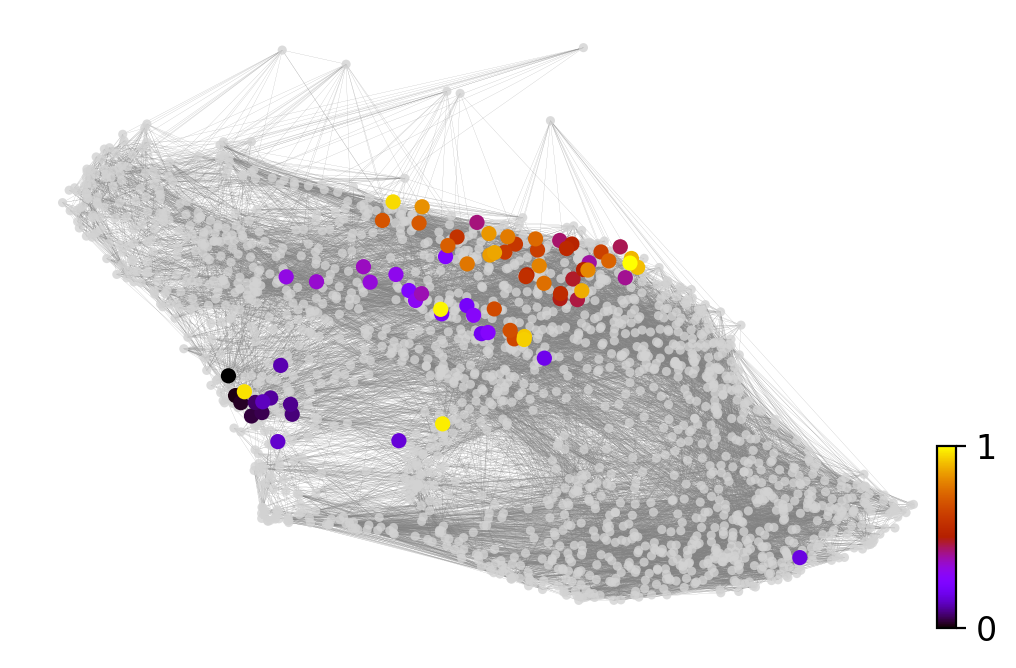

In [14]:
# Compute transition matrix for cell: AAACCCAAGGAGACCT
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=0)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

## Option #3: CellFate transition

This option looks promising? Seems exactly what we want? https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_cluster_fates.html#sphx-glr-auto-examples-plotting-plot-cluster-fates-py

The problem here is we need to define the terminal states. Here goes something.

**This is answering the oposite question. Which cluster ends up in what HTO tag.**

In [21]:
# Manually defined 4 terminal states. I have no idea how many should be there ???
cr.tl.terminal_states(
    adata,
    cluster_key="seurat_clusters",
    weight_connectivities=0.2,
    n_states=4,
#     softmax_scale=4,
    show_progress_bar=False,
)

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  
Accessing `adata.obsp['T_fwd']`
Using precomputed transition matrix
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


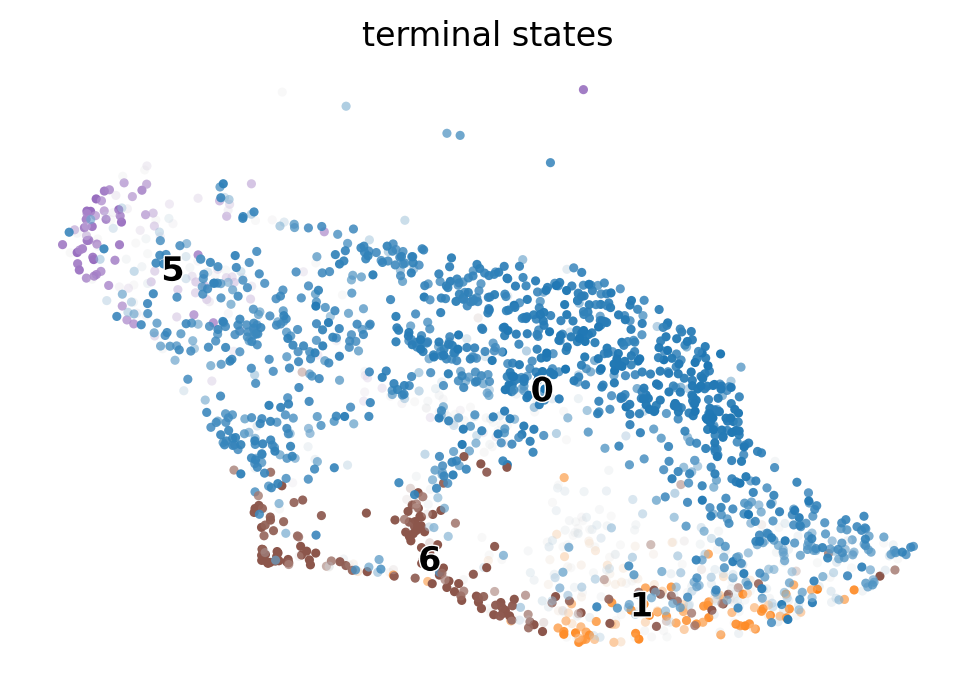

In [22]:
cr.pl.terminal_states(adata)

In [23]:
cr.tl.lineages(adata)

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


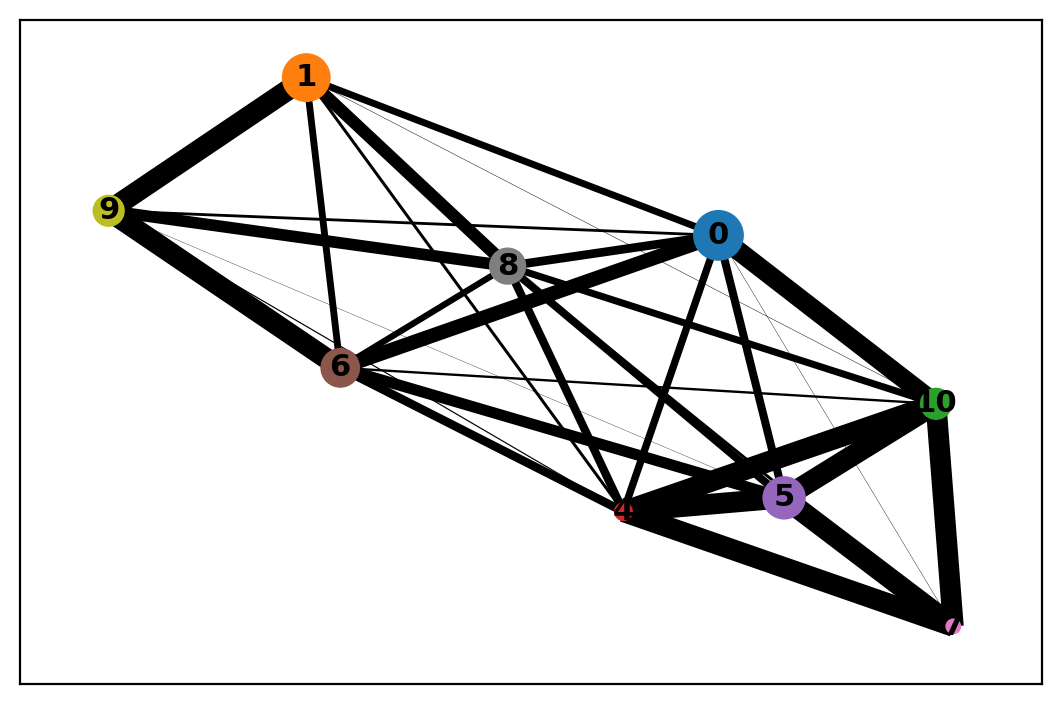

In [24]:
sc.tl.paga(adata, "seurat_clusters")
sc.pl.paga(adata)

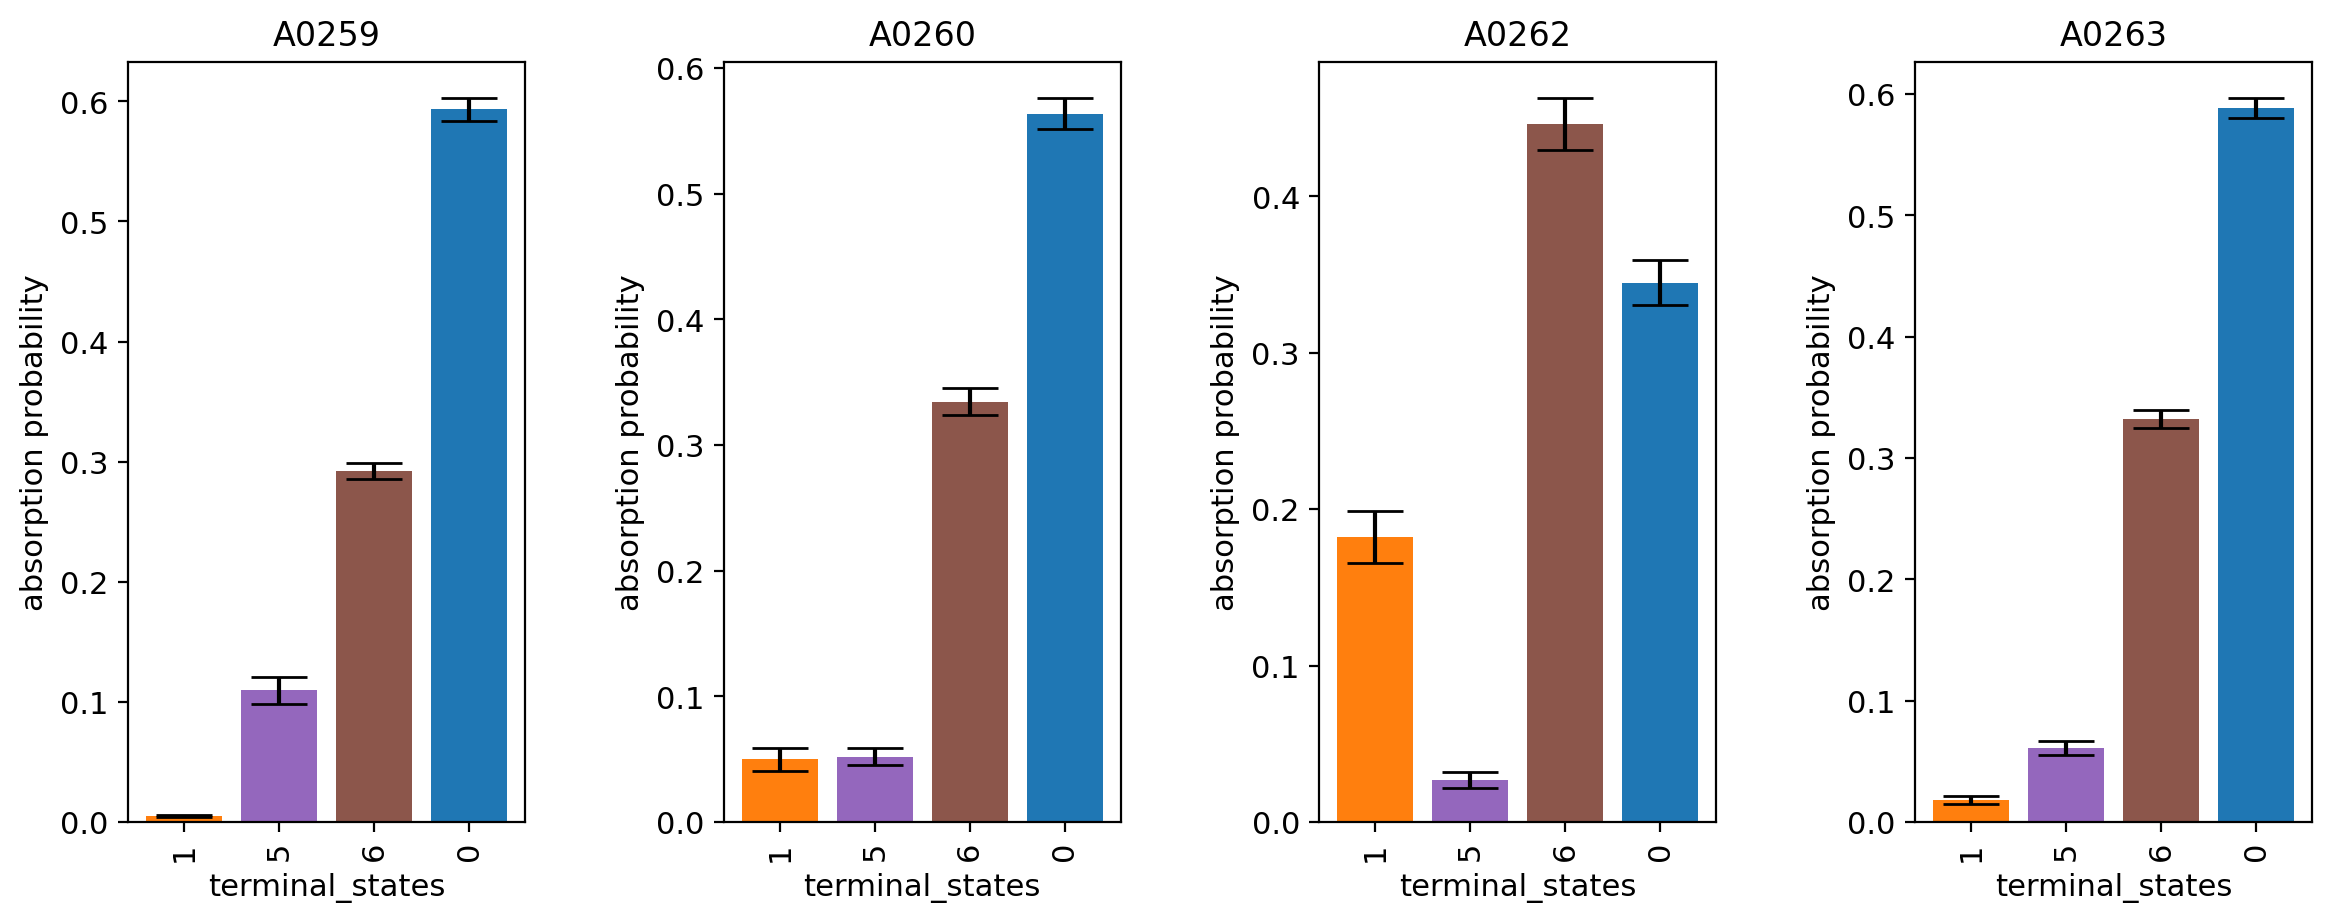

In [32]:
# Example explanation:
# Cluster #1: Higher change it ends up in A0262
# Cluster #5: Higher change it ends up in A0259
cr.pl.cluster_fates(adata, mode="bar", cluster_key="HTO")

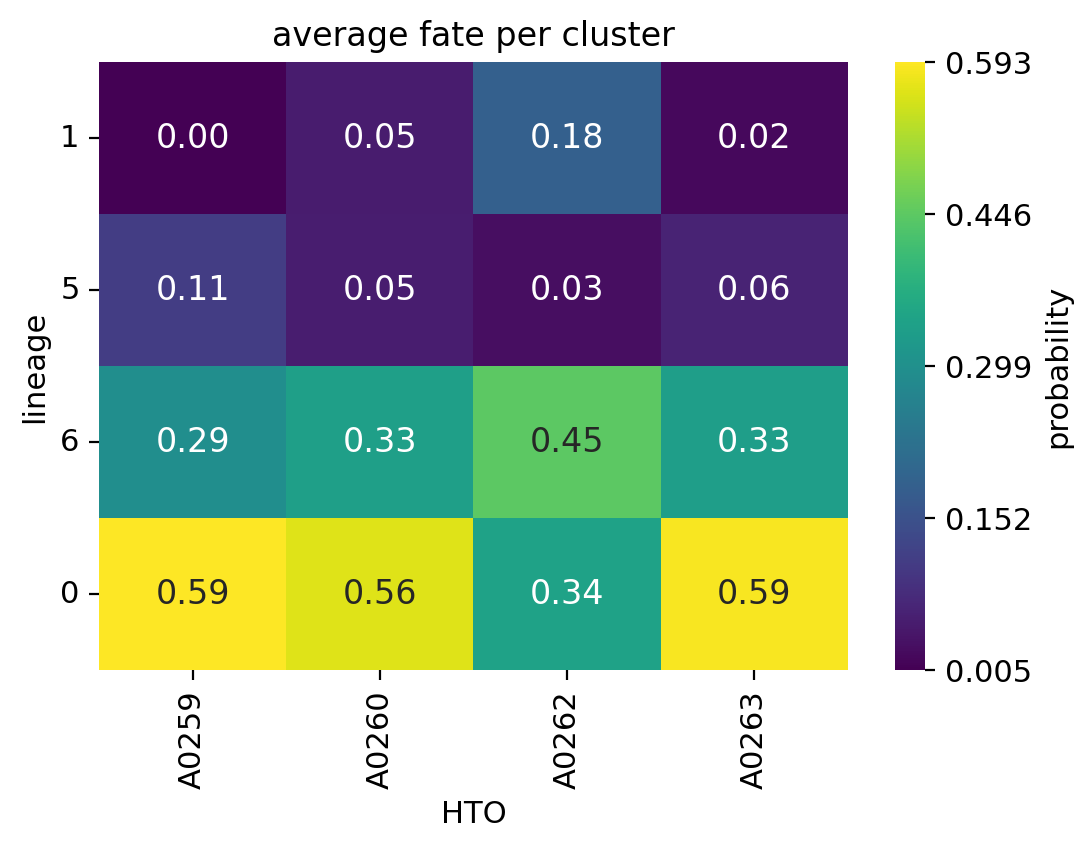

In [28]:
cr.pl.cluster_fates(adata, mode="heatmap", cluster_key="HTO")

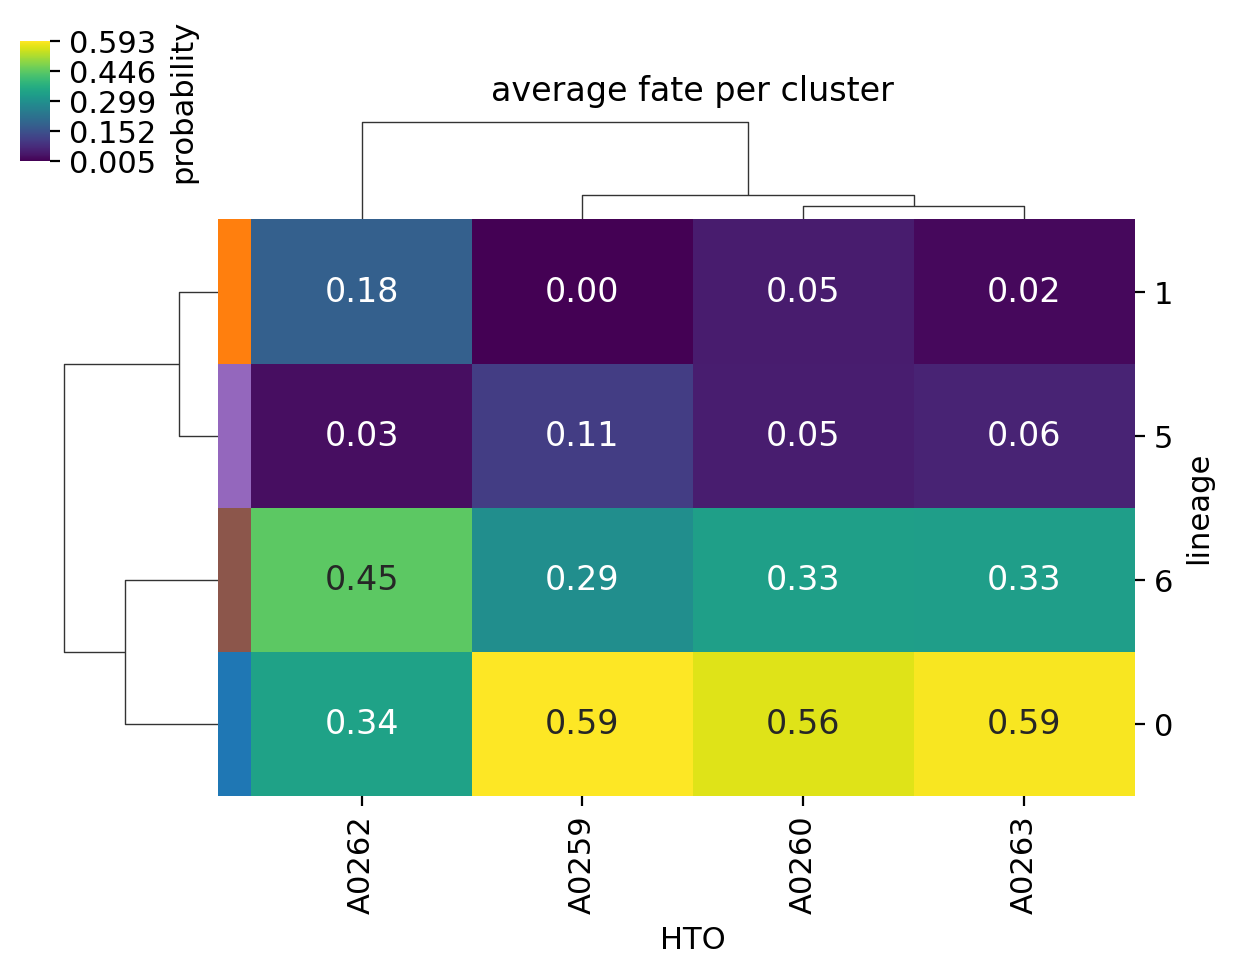

In [29]:
cr.pl.cluster_fates(adata, mode="clustermap", cluster_key="HTO")

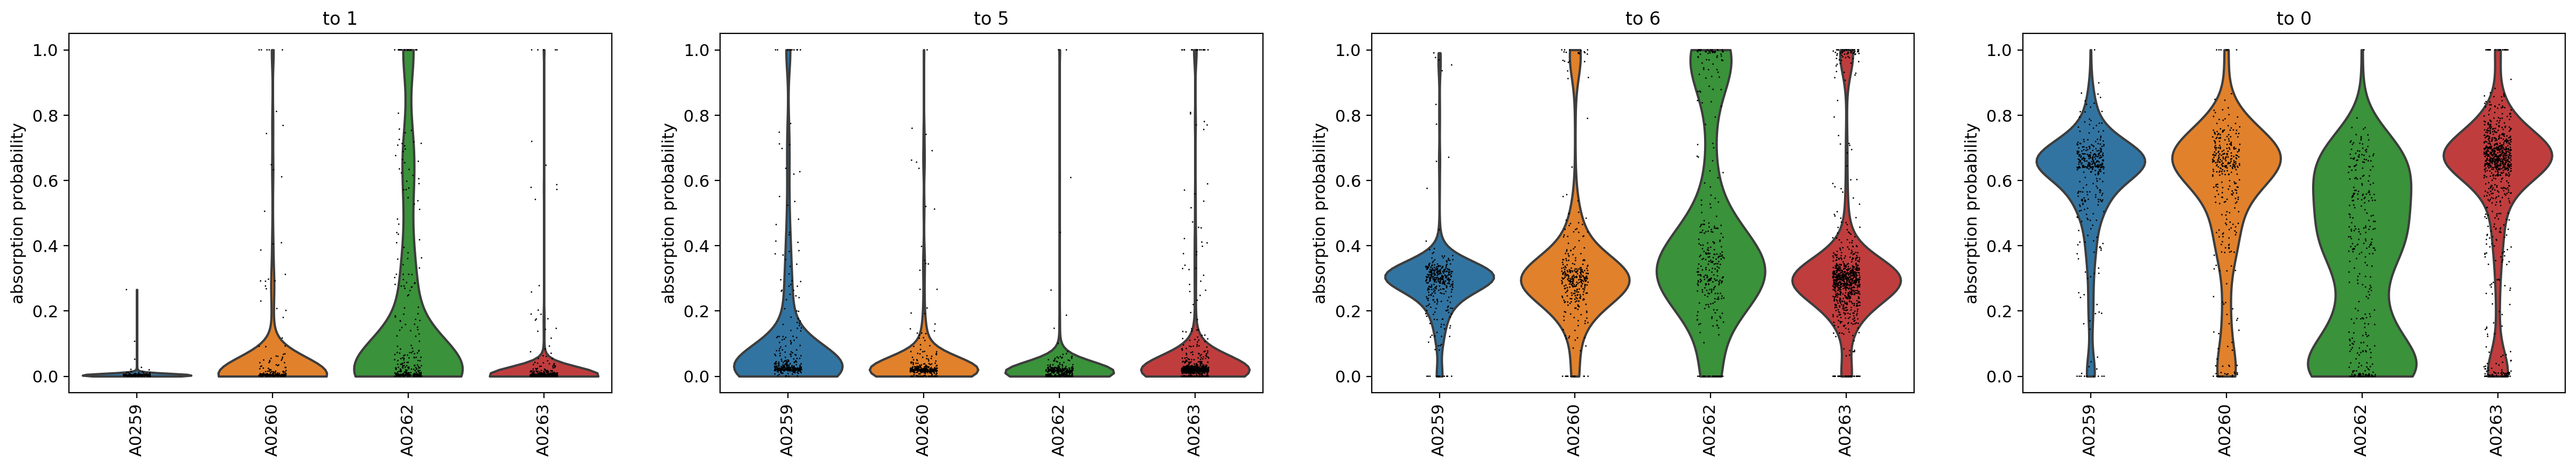

In [30]:
cr.pl.cluster_fates(adata, mode="violin", cluster_key="HTO")